In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import networkx
import matplotlib.pyplot as plt
from seirsplus.viral_model import ViralExtSEIRNetworkModel, VL_PARAMS
from seirsplus.sim_loops_pooled_test import SimulationRunner

import warnings
warnings.filterwarnings('ignore')

/home/yz685/anaconda3/envs/corr_pooling/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Goal: 
- write code for generating a simple network (start from just one household size, random extra edges)

In [3]:
from seirsplus.networks import generate_simplified_network

In [17]:
WEIGHT = 10
LoD=1240
POOL_SIZE=10
NUM_SCREENING_GROUPS = 5
ALPHA=2
INIT_PREV = 0.001
PEAK_VL=6

In [18]:
N=5000
household_size=5
p_random_edge=0.00

In [6]:
G, households_dict = generate_simplified_network(N, household_size, p_random_edge)

# assign higher weights to intra-household edges

import copy
G_weighted = copy.deepcopy(G)

for node, household in households_dict.items():
    for j in household:
        G[node][j]["weight"] = WEIGHT
        G_weighted[node][j]["weight"] = 10**10

In [7]:
G[0][1]

{'weight': 10}

In [8]:
G_weighted[0][1]

{'weight': 10000000000}

Text(0.5, 1.0, 'Degree distribution')

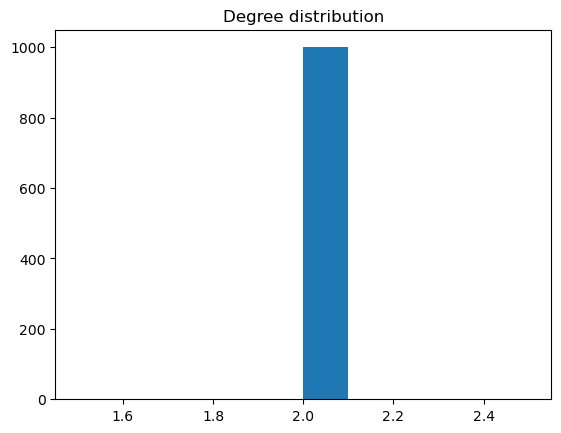

In [12]:
plt.hist([G.degree[i]-1 for i in range(N)])
plt.title("Degree distribution") # centered at 10+1000*0.01=20, as expected

In [6]:
def run_sim(
    G,
    G_weighted,
    households_dict,
    ALPHA,
    N,
    INIT_PREV,
    T,
    pooling_strategy,
    NUM_SCREENING_GROUPS,
    POOL_SIZE,
    LoD,
    peak_VL,
    seed=0,
):
    VL_params = copy.deepcopy(VL_PARAMS)
    for key in ["symptomatic", "asymptomatic"]:
        VL_params[key].update(
            {
                "peak_height": (peak_VL, peak_VL), 
                "start_peak": (3,5),
                "dt_peak": (1,1)
            }
        )

    
    test_model = ViralExtSEIRNetworkModel(
        G = G,
        G_weighted = G_weighted,
        households_dict=households_dict,
        beta = 0.1,
        beta_Q = 0,
        sigma = 0.2,
        lamda = 0.5,
        gamma  = 0.25,
        seed = seed,
        alpha = ALPHA,
        transition_mode="time_in_state",
        initE = N*INIT_PREV//2,
        initI_pre = N*INIT_PREV//2,
        # initI_pre = N*INIT_PREV,
        VL_params=VL_params,
        verbose=1
    )
    sim = SimulationRunner(
        model=test_model,
        pooling_strategy=pooling_strategy,
        T = T,
        # num_groups = 10,
        num_groups = NUM_SCREENING_GROUPS,
        pool_size = POOL_SIZE,
        LoD=LoD,
        seed = seed,
        save_results=False,
        verbose=2,
        max_dt=0.01,
    )
    sim.run_simulation()

    return sim

In [16]:
def plot_results(sim):
    fig, axs = plt.subplots(1, 5, figsize=(25, 3))

    axs[0].plot([sim.overall_results[i]["cumInfections"] for i in range(len(sim.overall_results))], "-o", label="cumulative infections")
    axs[0].plot([sim.overall_results[i]["numActiveInfections"] for i in range(len(sim.overall_results))], "-o", label="active infections")
    axs[0].plot([sim.overall_results[i]["cumRecovered"] for i in range(len(sim.overall_results))], "-o", label="cumulative recovered")
    axs[0].plot([sim.overall_results[i]["cum_positives_identified"] for i in range(len(sim.overall_results))], "-o", label="cumulative identified")
    axs[0].legend()
    axs[0].set_title("Infection counts")

    axs[2].plot([sim.overall_results[i]["mean_num_positives_in_positive_pool"] for i in range(len(sim.overall_results))], "-o", label="mean positives", color="tab:blue")
    axs[2].plot([sim.overall_results[i]["mean_num_identifiable_positives_in_positive_pool"] for i in range(len(sim.overall_results))], "-o", label="mean identifiable positives", color="tab:orange")
    # axs[2].plot([sim.overall_results[i]["median_num_positives_in_positive_pool"] for i in range(len(sim.overall_results))], "--^", label="median positives", color="tab:blue")
    axs[2].plot([sim.overall_results[i]["median_num_identifiable_positives_in_positive_pool"] for i in range(len(sim.overall_results))], "--^", label="median identifiable positives", color="tab:orange")
    axs[2].set_title("Number of positives in positive pools")
    axs[2].legend()

    axs[1].plot([sim.overall_results[i]["cum_num_tests"] for i in range(len(sim.overall_results))], "-o", label="cum_num_tests")
    axs[1].set_title("Cumulative test consumption")

    axs[3].plot([sim.overall_results[i]["daily_sensitivity"] for i in range(len(sim.overall_results))], "-o", label="daily_sensitivity")
    axs[3].set_title("Daily test sensitivity")

    axs[4].plot([sim.overall_results[i]["num_susceptible_neighbors_of_identified_positives"] for i in range(len(sim.overall_results))], "-o", label="identified positives")
    axs[4].plot([sim.overall_results[i]["num_susceptible_neighbors_of_unidentified_positives"] for i in range(len(sim.overall_results))], "-o", label="unidentified positives")
    axs[4].legend()
    axs[4].set_title("# susceptible neighbors")

In [8]:
G, households_dict = generate_simplified_network(N, household_size, p_random_edge)

# assign higher weights to intra-household edges

import copy
G_weighted = copy.deepcopy(G)

for node, household in households_dict.items():
    for j in household:
        G[node][j]["weight"] = WEIGHT
        G_weighted[node][j]["weight"] = 10**10
        
sim_correlated = run_sim(
    G,
    G_weighted,
    households_dict,
    ALPHA,
    N,
    INIT_PREV,
    T=30,
    pooling_strategy='correlated',
    NUM_SCREENING_GROUPS=NUM_SCREENING_GROUPS,
    POOL_SIZE=10,
    LoD=LoD,
    peak_VL=PEAK_VL,
    seed=0,
)


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


Running simulation with seed 0 for strategy correlated...
Running screening for group 0 on day 0...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 45.30it/s]


Viral loads in positive pools:  [[(926, -1.0, 3.0)], [(857, -1.0, 3.0)], [(740, -1.0, 3.0)]]
Screening day:  0  self.model.t:  0.01
    Nodes with transition propensities:
        node925, in state [1], propensity [('StoE', 0.4)]
infected: 925, transmissionTerms_I: [10.], transmissionTerms_Q: [0.], household_neighbors: {928, 929, 926, 927}, non_household_neighbors: [925]
Household member states: [array([1]), array([1]), array([3]), array([1])]
Non-household member states: [array([2])]
Infected node 925 got contribution from infectious contacts {926: 1.0} and quarantined contacts {}
{'t': 0.09714844218526272, 'transitionNode': 925, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
propensity: 0.4, sum of all propensities: 16.0
    Nodes with transition propensities:
        node844, in state [1], propensity [('StoE', 0.4)]
infected: 844, transmissionTerms_I: [10.], transmissionTerms_Q: [0.], household_neighbors: {840, 841, 842, 843}, non_household_neighbors: [844]
Household member stat

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 24.79it/s]


Viral loads in positive pools:  [[(251, 0.11, 2.11), (253, 0.12, 2.08), (254, -1.0, 3.56)], [(754, -1.0, 3.71)]]
Screening day:  1  self.model.t:  1.006465257678239
    Nodes with transition propensities:
        node753, in state [1], propensity [('StoE', 0.4)]
infected: 753, transmissionTerms_I: [10.], transmissionTerms_Q: [0.], household_neighbors: {752, 754, 750, 751}, non_household_neighbors: [753]
Household member states: [array([1]), array([3]), array([1]), array([1])]
Non-household member states: [array([2])]
Infected node 753 got contribution from infectious contacts {754: 1.0} and quarantined contacts {}
{'t': 1.0604472229439446, 'transitionNode': 753, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
propensity: 0.4, sum of all propensities: 10.400000000000002
    Nodes with transition propensities:
        node925, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 925 is transitioning EtoIPRE at time 1.1004476686299733 with timer_state: [1.00329923]; 1/sigma: [1.]; 

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 33.96it/s]


Viral loads in positive pools:  [[(806, 1.93, 0.04), (807, -1.0, 4.49), (808, 0.65, 3.2), (809, 0.47, 3.44), (840, -1.0, 4.27), (842, 1.53, 1.24), (843, 0.25, 3.59)], [(200, 1.81, 0.39), (202, -1.0, 4.9), (203, 1.76, 0.56), (204, 1.25, 2.07)], [(844, 0.11, 3.71)], [(310, 0.7, 3.2), (311, 1.44, 1.5), (312, 1.23, 2.15), (314, -1.0, 4.32)]]
Screening day:  2  self.model.t:  2.002531909628552
    Nodes with transition propensities:
        node753, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 753 is transitioning EtoIPRE at time 2.0625319300255223 with timer_state: [1.00208471]; 1/sigma: [1.]; VL: 2.6462540600538222
{'t': 2.0625319300255223, 'transitionNode': 753, 'transitionNodeVL': 3.0013187373323484, 'transitionType': 'EtoIPRE'}
propensity: 100000.0, sum of all propensities: 100006.4
    Nodes with transition propensities:
        node250, in state [1], propensity [('StoE', 1.2)]
infected: 250, transmissionTerms_I: [30.], transmissionTerms_Q: [0.], household_neighbors: {251,

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 33.97it/s]


Viral loads in positive pools:  []
Screening day:  3  self.model.t:  3.003267241958212
    Nodes with transition propensities:
        node250, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 250 is transitioning EtoIPRE at time 3.083270595815817 with timer_state: [1.00786567]; 1/sigma: [1.]; VL: 2.603586957033606
{'t': 3.083270595815817, 'transitionNode': 250, 'transitionNodeVL': 3.0064363062109165, 'transitionType': 'EtoIPRE'}
propensity: 100000.0, sum of all propensities: 100004.0
    Nodes with transition propensities:
        node741, in state [1], propensity [('StoE', 1.2)]
infected: 741, transmissionTerms_I: [30.], transmissionTerms_Q: [0.], household_neighbors: {744, 740, 742, 743}, non_household_neighbors: [741]
Household member states: [array([3]), array([3]), array([3]), array([1])]
Non-household member states: [array([2])]
Infected node 741 got contribution from infectious contacts {744: 0.333, 740: 0.333, 742: 0.333} and quarantined contacts {}
{'t': 3.21264484894

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 42.12it/s]


Viral loads in positive pools:  [[(955, 0.7, 4.86), (956, 1.43, 3.91), (957, 0.4, 4.67), (958, 0.18, 4.89), (959, -1.0, 5.88)]]
Screening day:  4  self.model.t:  4.002682367131913
    Nodes with transition propensities:
        node202, in state [3], propensity [('IPREtoISYM', 100000.0)]
-- node 202 is transitioning IPREtoISYM at time 4.082725410135368 with timer_state: [4.08272541]; 1/lamda: [4.07419699]; VL: 6.0
{'t': 4.082725410135368, 'transitionNode': 202, 'transitionNodeVL': 5.997254977894949, 'transitionType': 'IPREtoISYM'}
propensity: 100000.0, sum of all propensities: 100002.8
    Nodes with transition propensities:
        node926, in state [3], propensity [('IPREtoISYM', 100000.0)]
-- node 926 is transitioning IPREtoISYM at time 4.102727751768094 with timer_state: [4.10272775]; 1/lamda: [4.09638546]; VL: 6.0
{'t': 4.102727751768094, 'transitionNode': 926, 'transitionNodeVL': 5.997867381042524, 'transitionType': 'IPREtoISYM'}
propensity: 100000.0, sum of all propensities: 100

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 35.32it/s]


Viral loads in positive pools:  [[(925, 0.1, 6.0), (926, -1.0, 5.72), (927, 1.94, 4.29), (928, 0.82, 5.34), (929, 1.55, 5.2)], [(855, 0.6, 5.27), (856, 0.32, 6.0), (857, -1.0, 5.95), (858, 1.94, 4.28), (859, 1.67, 4.47)], [(740, -1.0, 6.0), (741, 3.21, 3.43), (742, 1.15, 4.68), (743, 4.42, 1.5), (744, 1.32, 5.21)]]
Screening day:  5  self.model.t:  5.003042196014405
    Nodes with transition propensities:
        node805, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 805 is transitioning EtoIPRE at time 5.203042742612676 with timer_state: [1.0013076]; 1/sigma: [1.]; VL: 2.163921149036267
{'t': 5.203042742612676, 'transitionNode': 805, 'transitionNodeVL': 3.0009587319626623, 'transitionType': 'EtoIPRE'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node254, in state [3], propensity [('IPREtoISYM', 100000.0)]
-- node 254 is transitioning IPREtoISYM at time 5.363044179760998 with timer_state: [5.36304418]; 1/lamda: [5.35

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 34.61it/s]


Viral loads in positive pools:  [[(750, 2.32, 4.63)], [(250, 2.08, 5.31), (251, 0.11, 5.92), (252, 1.44, 5.92), (253, 0.12, 5.91), (254, -1.0, 5.83)], [(751, 1.11, 6.0), (752, 2.6, 4.59), (753, 1.06, 5.42), (754, -1.0, 5.52)]]
Screening day:  6  self.model.t:  6.003135567624743
    Nodes with transition propensities:
        node958, in state [13], propensity [('QPREtoQSYM', 100000.0)]
-- node 958 is transitioning QPREtoQSYM at time 6.1431396140585965 with timer_state: [4.96006305]; 1/lamda: [4.95953363]; VL: 6.0
{'t': 6.1431396140585965, 'transitionNode': 958, 'transitionNodeVL': 5.999373777667604, 'transitionType': 'QPREtoQSYM'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node310, in state [3], propensity [('IPREtoISYM', 100000.0)]
-- node 310 is transitioning IPREtoISYM at time 6.343144953682157 with timer_state: [4.63506668]; 1/lamda: [4.62789883]; VL: 6.0
{'t': 6.343144953682157, 'transitionNode': 310, 'transitionNodeVL':

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 34.43it/s]


Viral loads in positive pools:  [[(312, 1.23, 6.0)], [(843, 0.25, 5.56)], [(200, 1.81, 5.92), (201, 2.66, 6.0), (203, 1.76, 5.96), (204, 1.25, 5.99)], [(202, -1.0, 5.08)], [(805, 4.2, 4.28), (806, 1.93, 6.0), (807, -1.0, 5.39), (808, 0.65, 6.0), (809, 0.47, 5.54), (840, -1.0, 5.59), (841, 2.25, 6.0), (842, 1.53, 5.82), (844, 0.11, 5.6)], [(310, 0.7, 5.75), (311, 1.44, 5.83), (313, 2.23, 5.58), (314, -1.0, 5.45)]]
Screening day:  7  self.model.t:  7.0032373024703505
    Nodes with transition propensities:
        node252, in state [13], propensity [('QPREtoQSYM', 100000.0)]
-- node 252 is transitioning QPREtoQSYM at time 7.003240149644957 with timer_state: [4.55906017]; 1/lamda: [4.5507269]; VL: 6.0
{'t': 7.003240149644957, 'transitionNode': 252, 'transitionNodeVL': 5.996204670116311, 'transitionType': 'QPREtoQSYM'}
propensity: 100000.0, sum of all propensities: 200000.0
    Nodes with transition propensities:
        node855, in state [13], propensity [('QPREtoQSYM', 100000.0)]
-- node

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 34.40it/s]


Viral loads in positive pools:  []
Screening day:  8  self.model.t:  8.00330113569001
    Nodes with transition propensities:
        node200, in state [13], propensity [('QPREtoQSYM', 100000.0)]
-- node 200 is transitioning QPREtoQSYM at time 8.073322544950376 with timer_state: [5.26007288]; 1/lamda: [5.25166283]; VL: 6.0
{'t': 8.073322544950376, 'transitionNode': 200, 'transitionNodeVL': 5.996811301888834, 'transitionType': 'QPREtoQSYM'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node742, in state [13], propensity [('QPREtoQSYM', 100000.0)]
-- node 742 is transitioning QPREtoQSYM at time 8.113323116961471 with timer_state: [5.95790819]; 1/lamda: [5.95633799]; VL: 6.0
{'t': 8.113323116961471, 'transitionNode': 742, 'transitionNodeVL': 5.99874434404929, 'transitionType': 'QPREtoQSYM'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node311, in state [13], propensity [('Q

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 46.03it/s]


Viral loads in positive pools:  [[(956, 1.43, 5.4)]]
Screening day:  9  self.model.t:  9.003411813966688
    Nodes with transition propensities:
        node750, in state [3], propensity [('IPREtoISYM', 100000.0)]
-- node 750 is transitioning IPREtoISYM at time 9.06342674041687 with timer_state: [5.73074779]; 1/lamda: [5.72813494]; VL: 6.0
{'t': 9.06342674041687, 'transitionNode': 750, 'transitionNodeVL': 5.995533795773046, 'transitionType': 'IPREtoISYM'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node743, in state [3], propensity [('IPREtoISYM', 100000.0)]
-- node 743 is transitioning IPREtoISYM at time 9.71342753216609 with timer_state: [4.29037066]; 1/lamda: [4.28386679]; VL: 6.0
{'t': 9.71342753216609, 'transitionNode': 743, 'transitionNodeVL': 5.997403417783389, 'transitionType': 'IPREtoISYM'}
propensity: 100000.0, sum of all propensities: 100000.0
Running screening for group 0 on day 10...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 47.69it/s]


Viral loads in positive pools:  [[(858, 1.94, 5.6)], [(741, 3.21, 6.0), (743, 4.42, 6.0), (927, 1.94, 5.53)]]
Screening day:  10  self.model.t:  10.003427532166084
    Nodes with transition propensities:
        node741, in state [13], propensity [('QPREtoQSYM', 100000.0)]
-- node 741 is transitioning QPREtoQSYM at time 10.193430701503749 with timer_state: [5.97169522]; 1/lamda: [5.96918652]; VL: 6.0
{'t': 10.193430701503749, 'transitionNode': 741, 'transitionNodeVL': 5.9958530679103825, 'transitionType': 'QPREtoQSYM'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node805, in state [3], propensity [('IPREtoISYM', 100000.0)]
-- node 805 is transitioning IPREtoISYM at time 10.303432553856148 with timer_state: [5.10038981]; 1/lamda: [5.0916429]; VL: 6.0
{'t': 10.303432553856148, 'transitionNode': 805, 'transitionNodeVL': 5.996666293015851, 'transitionType': 'IPREtoISYM'}
propensity: 100000.0, sum of all propensities: 100000.0
Runni

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 36.77it/s]


Viral loads in positive pools:  [[(750, 2.32, 5.5)]]
Screening day:  11  self.model.t:  11.003432553856133
Running screening for group 2 on day 12...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 41.36it/s]


Viral loads in positive pools:  [[(202, -1.0, 4.0), (805, 4.2, 6.0)]]
Screening day:  12  self.model.t:  12.003432553856111
Running screening for group 3 on day 13...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 45.30it/s]


Viral loads in positive pools:  []
Screening day:  13  self.model.t:  13.00343255385609
Running screening for group 4 on day 14...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 34.97it/s]


Viral loads in positive pools:  [[(956, 1.43, 4.83)]]
Screening day:  14  self.model.t:  14.003432553856069
Running screening for group 0 on day 15...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 37.82it/s]


Viral loads in positive pools:  []
Screening day:  15  self.model.t:  15.003432553856047
Running screening for group 1 on day 16...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 37.46it/s]


Viral loads in positive pools:  []
Screening day:  16  self.model.t:  16.003432553856026
Running screening for group 2 on day 17...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 38.12it/s]


Viral loads in positive pools:  [[(202, -1.0, 4.0)]]
Screening day:  17  self.model.t:  17.003432553856182
Running screening for group 3 on day 18...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 28.61it/s]


Viral loads in positive pools:  []
Screening day:  18  self.model.t:  18.00343255385634
    Nodes with transition propensities:
        node740, in state [14], propensity [('QSYMtoQR', 100000.0)]
{'t': 18.293438236315794, 'transitionNode': 740, 'transitionNodeVL': -1.0, 'transitionType': 'QSYMtoQR'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node926, in state [14], propensity [('QSYMtoQR', 100000.0)]
{'t': 18.36343958273506, 'transitionNode': 926, 'transitionNodeVL': -1.0, 'transitionType': 'QSYMtoQR'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node856, in state [14], propensity [('QSYMtoQR', 100000.0)]
{'t': 18.413442749303776, 'transitionNode': 856, 'transitionNodeVL': -1.0, 'transitionType': 'QSYMtoQR'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node857, in state [14], propensity [('QSYMtoQR', 100000.0)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 34.33it/s]


Viral loads in positive pools:  [[(955, 0.7, 3.0), (956, 1.43, 3.0), (957, 0.4, 3.0)]]
Screening day:  19  self.model.t:  19.003471846286747
    Nodes with transition propensities:
        node310, in state [14], propensity [('QSYMtoQR', 100000.0)]
{'t': 19.013485219936623, 'transitionNode': 310, 'transitionNodeVL': -1.0, 'transitionType': 'QSYMtoQR'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node809, in state [14], propensity [('QSYMtoQR', 100000.0)]
{'t': 19.243487385486503, 'transitionNode': 809, 'transitionNodeVL': -1.0, 'transitionType': 'QSYMtoQR'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node202, in state [4], propensity [('ISYMtoR', 100000.0)]
-- node 202 is transitioning ISYMtoR at time 19.3134880558809 with timer_state: [15.23076265]; 1/gamma: [15.2228145]; VL: 3.0
{'t': 19.3134880558809, 'transitionNode': 202, 'transitionNodeVL': -1.0, 'transitionType'

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 35.03it/s]


Viral loads in positive pools:  [[(742, 1.15, 3.0), (744, 1.32, 3.0)], [(929, 1.55, 3.0)], [(855, 0.6, 3.0), (859, 1.67, 3.0)]]
Screening day:  20  self.model.t:  20.0035726102602
    Nodes with transition propensities:
        node252, in state [4], propensity [('ISYMtoR', 100000.0)]
-- node 252 is transitioning ISYMtoR at time 20.093579488369702 with timer_state: [13.09033934]; 1/gamma: [13.08458339]; VL: 3.0
{'t': 20.093579488369702, 'transitionNode': 252, 'transitionNodeVL': -1.0, 'transitionType': 'ISYMtoR'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node751, in state [4], propensity [('ISYMtoR', 100000.0)]
-- node 751 is transitioning ISYMtoR at time 20.23360319214345 with timer_state: [13.81044745]; 1/gamma: [13.8096624]; VL: 3.0
{'t': 20.23360319214345, 'transitionNode': 751, 'transitionNodeVL': -1.0, 'transitionType': 'ISYMtoR'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propens

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 36.41it/s]


Viral loads in positive pools:  [[(752, 2.6, 3.0), (753, 1.06, 3.0)]]
Screening day:  21  self.model.t:  21.003723896325038
    Nodes with transition propensities:
        node842, in state [4], propensity [('ISYMtoR', 100000.0)]
-- node 842 is transitioning ISYMtoR at time 21.153724767419618 with timer_state: [12.910367]; 1/gamma: [12.90090508]; VL: 3.0
{'t': 21.153724767419618, 'transitionNode': 842, 'transitionNodeVL': -1.0, 'transitionType': 'ISYMtoR'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node840, in state [4], propensity [('ISYMtoR', 100000.0)]
-- node 840 is transitioning ISYMtoR at time 21.213731436224727 with timer_state: [15.61062763]; 1/gamma: [15.60088049]; VL: 3.0
{'t': 21.213731436224727, 'transitionNode': 840, 'transitionNodeVL': -1.0, 'transitionType': 'ISYMtoR'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node855, in state [4], propensity [('ISY

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 45.45it/s]


Viral loads in positive pools:  [[(311, 1.44, 3.0), (312, 1.23, 3.0), (313, 2.23, 3.0)], [(200, 1.81, 3.0)]]
Screening day:  22  self.model.t:  22.00379756963371
    Nodes with transition propensities:
        node753, in state [4], propensity [('ISYMtoR', 100000.0)]
-- node 753 is transitioning ISYMtoR at time 22.27379997195225 with timer_state: [14.46052215]; 1/gamma: [14.46021255]; VL: 3.0
{'t': 22.27379997195225, 'transitionNode': 753, 'transitionNodeVL': -1.0, 'transitionType': 'ISYMtoR'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node858, in state [14], propensity [('QSYMtoQR', 100000.0)]
{'t': 22.34381158776779, 'transitionNode': 858, 'transitionNodeVL': -1.0, 'transitionType': 'QSYMtoQR'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node752, in state [4], propensity [('ISYMtoR', 100000.0)]
-- node 752 is transitioning ISYMtoR at time 22.543816757329193 with ti

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 33.72it/s]


Viral loads in positive pools:  []
Screening day:  23  self.model.t:  23.00383842207231
    Nodes with transition propensities:
        node311, in state [4], propensity [('ISYMtoR', 100000.0)]
-- node 311 is transitioning ISYMtoR at time 23.163844553567074 with timer_state: [14.94051261]; 1/gamma: [14.93229955]; VL: 3.0
{'t': 23.163844553567074, 'transitionNode': 311, 'transitionNodeVL': -1.0, 'transitionType': 'ISYMtoR'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node200, in state [4], propensity [('ISYMtoR', 100000.0)]
-- node 200 is transitioning ISYMtoR at time 23.193850365722806 with timer_state: [15.12052782]; 1/gamma: [15.11743597]; VL: 3.0
{'t': 23.193850365722806, 'transitionNode': 200, 'transitionNodeVL': -1.0, 'transitionType': 'ISYMtoR'}
propensity: 100000.0, sum of all propensities: 100000.0
Running screening for group 4 on day 24...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 33.10it/s]


Viral loads in positive pools:  []
Screening day:  24  self.model.t:  24.003850365722933
    Nodes with transition propensities:
        node741, in state [4], propensity [('ISYMtoR', 100000.0)]
-- node 741 is transitioning ISYMtoR at time 24.003881337487623 with timer_state: [13.81045064]; 1/gamma: [13.80669616]; VL: 3.0
{'t': 24.003881337487623, 'transitionNode': 741, 'transitionNodeVL': -1.0, 'transitionType': 'ISYMtoR'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node313, in state [4], propensity [('ISYMtoR', 100000.0)]
-- node 313 is transitioning ISYMtoR at time 24.363900450788936 with timer_state: [15.81053632]; 1/gamma: [15.80932076]; VL: 3.0
{'t': 24.363900450788936, 'transitionNode': 313, 'transitionNodeVL': -1.0, 'transitionType': 'ISYMtoR'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node805, in state [14], propensity [('QSYMtoQR', 100000.0)]
{'t': 24.4339

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 33.39it/s]


Viral loads in positive pools:  []
Screening day:  25  self.model.t:  25.003901119664125
Running screening for group 1 on day 26...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 31.50it/s]


Viral loads in positive pools:  []
Screening day:  26  self.model.t:  26.00390111966428


In [12]:
for household in households_dict.values():
    if any(sim_correlated.model.infection_start_times[node_]<100000 for node_ in household):
        print([sim_correlated.model.infection_start_times[node_] for node_ in household])


[8.674867851824354, 4.038947672207486, 0.0, 100000.0, 100000.0]
[8.674867851824354, 4.038947672207486, 0.0, 100000.0, 100000.0]
[8.674867851824354, 4.038947672207486, 0.0, 100000.0, 100000.0]
[8.674867851824354, 4.038947672207486, 0.0, 100000.0, 100000.0]
[8.674867851824354, 4.038947672207486, 0.0, 100000.0, 100000.0]
[4.480266170361848, 1.595218387894002, 0.12014420733005378, 2.3245658765534625, -3.7255719627067787]
[4.480266170361848, 1.595218387894002, 0.12014420733005378, 2.3245658765534625, -3.7255719627067787]
[4.480266170361848, 1.595218387894002, 0.12014420733005378, 2.3245658765534625, -3.7255719627067787]
[4.480266170361848, 1.595218387894002, 0.12014420733005378, 2.3245658765534625, -3.7255719627067787]
[4.480266170361848, 1.595218387894002, 0.12014420733005378, 2.3245658765534625, -3.7255719627067787]
[6.164683301814558, 4.9315077852968665, 6.613420324983231, 5.679325444961704, 0.0]
[6.164683301814558, 4.9315077852968665, 6.613420324983231, 5.679325444961704, 0.0]
[6.164683

In [31]:
for i in range(len(sim_correlated.overall_results)):
    vls_l = sim_correlated.overall_results[i]["VL_in_positive_pools"]
    for vls in vls_l:
        print(vls, [(vl[2]>4.4, vl[2]>4.4+np.log10(20)) for vl in vls])
        print(np.log10(sum([10**vl[2] for vl in vls]))>4.4+np.log10(20))


[(926, -1.0, 3.0)] [(False, False)]
False
[(857, -1.0, 3.0)] [(False, False)]
False
[(740, -1.0, 3.0)] [(False, False)]
False
[(251, 0.11, 2.11), (253, 0.12, 2.08), (254, -1.0, 3.56)] [(False, False), (False, False), (False, False)]
False
[(754, -1.0, 3.71)] [(False, False)]
False
[(806, 1.93, 0.04), (807, -1.0, 4.49), (808, 0.65, 3.2), (809, 0.47, 3.44), (840, -1.0, 4.27), (842, 1.53, 1.24), (843, 0.25, 3.59)] [(False, False), (True, False), (False, False), (False, False), (False, False), (False, False), (False, False)]
False
[(200, 1.81, 0.39), (202, -1.0, 4.9), (203, 1.76, 0.56), (204, 1.25, 2.07)] [(False, False), (True, False), (False, False), (False, False)]
False
[(844, 0.11, 3.71)] [(False, False)]
False
[(310, 0.7, 3.2), (311, 1.44, 1.5), (312, 1.23, 2.15), (314, -1.0, 4.32)] [(False, False), (False, False), (False, False), (False, False)]
False
[(955, 0.7, 4.86), (956, 1.43, 3.91), (957, 0.4, 4.67), (958, 0.18, 4.89), (959, -1.0, 5.88)] [(True, False), (False, False), (True, 

In [9]:
from seirsplus.VL_progression import _get_vl_with_plateau, gen_vl_distribution_with_plateau

def plot_real_vl_curve(infection_start_time, critical_time_points):
    # critical_time_points[0] = infection_start_time
    for i in range(1,4):
        critical_time_points[i] += critical_time_points[i-1]
    peak_plateau_height = 6
    tail_plateau_height = 3

    vls = []
    sample_times = np.linspace(0, 30, 61)
    pre_sample_times = np.linspace(-5, 0, 10, endpoint=False)
    pre_sample_vls = np.ones(10)*-1

    for sample_time in sample_times:
        vls.append(_get_vl_with_plateau(
            critical_time_points,
            peak_plateau_height,
            tail_plateau_height,
            sample_time
        ))

    plt.rcParams["font.family"] = 'serif'
    plt.plot(np.concatenate((pre_sample_times, sample_times)), np.concatenate((pre_sample_vls, vls)))
    plt.title("log10 viral load over time")
    plt.xlabel("time (days) since infection")
    plt.ylabel("log10 viral load")

925 5.003042196014405
926 5.003042196014405
927 10.003427532166084
928 5.003042196014405
929 5.003042196014405


Text(0.5, 1.0, 'Recorded viral load (solid) and underlying model values (dashed)')

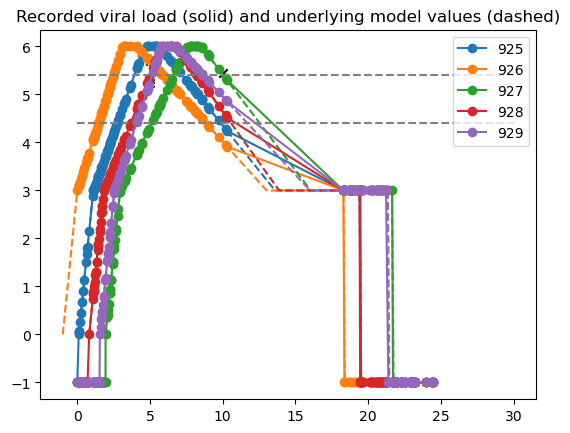

In [10]:
from seirsplus.VL_progression import _get_vl_with_plateau, gen_vl_distribution_with_plateau

# plt.figure(figsize=(15,8))

# for i in [955, 956, 957, 958, 959]:
for i in range(925,930):
# for i in [740, 741, 742]:
    # plot recorded infection curves (recording times = times at which a transition happened;
    # might be sparse if initial prevalence is low)
    plt.plot(
        sim_correlated.model.VL_over_time["time_points"],
        sim_correlated.model.VL_over_time["VL_time_series"][i],
        '-o',
        label=str(i), 
    )

    # plot underlying model values to make sure the recorded values match
    tmp = []
    time_range = np.linspace(
        sim_correlated.model.infection_start_times[i], 
        sim_correlated.model.infection_start_times[i] + 20, 
        201
    )
    for t in time_range:
        tmp.append(
            _get_vl_with_plateau(
                critical_time_points = sim_correlated.model.VL_params_by_node[i]["critical_time_points"],
                peak_plateau_height = sim_correlated.model.VL_params_by_node[i]["peak_plateau_height"],
                tail_height = sim_correlated.model.VL_params_by_node[i]["tail_height"],
                sample_time = t - sim_correlated.model.infection_start_times[i]
            )
        )
    plt.plot(time_range, tmp, '--', color=plt.gca().lines[-1].get_color())

    print(i, sim_correlated.model.isolation_start_times[i])

    plt.scatter(
        sim_correlated.model.isolation_start_times[i], 
        tmp[int((sim_correlated.model.isolation_start_times[i]-sim_correlated.model.infection_start_times[i])/0.1)], 
        # 0,
        marker='x', 
        # color=plt.gca().lines[-1].get_color(), edgecolors="white",
        color="k"
    )
plt.legend()

plt.hlines(4.4, 0, 30, linestyles='dashed', colors='grey')
plt.hlines(4.4+np.log10(sim_correlated.pool_size), 0, 30, linestyles='dashed', colors='grey')

plt.title("Recorded viral load (solid) and underlying model values (dashed)")

In [17]:
sim_correlated.model.isolation_start_times[1]

100000.0

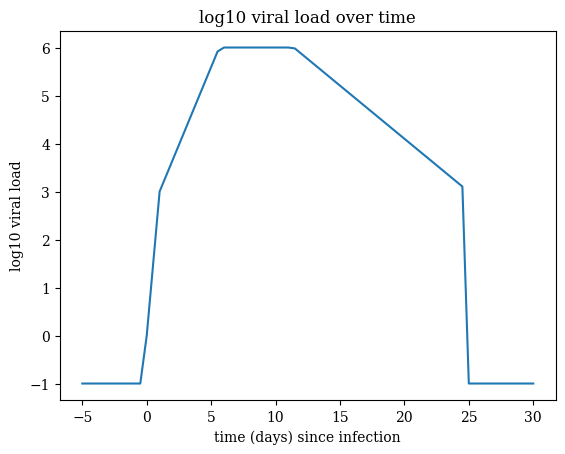

In [88]:

critical_time_points = sim_correlated.model.VL_params_by_node[955]["critical_time_points"]
# if we are sampling time intervals rather than time points, convert to time points
for i in range(1,4):
    critical_time_points[i] += critical_time_points[i-1]
peak_plateau_height = 6
tail_plateau_height = 3

vls = []
sample_times = np.linspace(0, 30, 61)
pre_sample_times = np.linspace(-5, 0, 10, endpoint=False)
pre_sample_vls = np.ones(10)*-1

for sample_time in sample_times:
    vls.append(_get_vl_with_plateau(
        critical_time_points,
        peak_plateau_height,
        tail_plateau_height,
        sample_time
    ))

plt.rcParams["font.family"] = 'serif'
plt.plot(np.concatenate((pre_sample_times, sample_times)), np.concatenate((pre_sample_vls, vls)))
plt.title("log10 viral load over time")
plt.xlabel("time (days) since infection")
plt.ylabel("log10 viral load")
plt.savefig(f'../figures/VL.pdf')


Text(0.5, 1.0, 'Distribution of secondary infections per infectious case, CP')

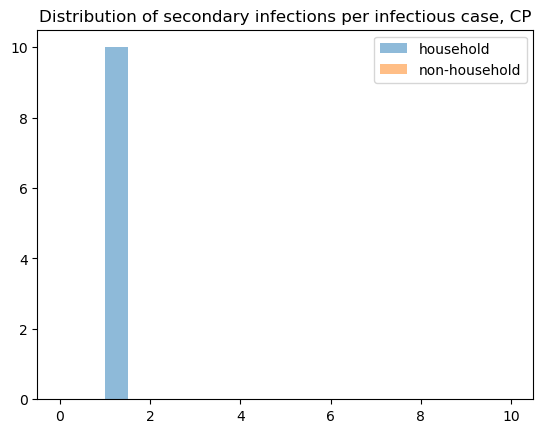

In [17]:
bins=np.linspace(0,10,21)
plt.hist(sim_correlated.model.sec_infs_household.values(), bins=bins, alpha=0.5, label="household")
plt.hist(sim_correlated.model.sec_infs_non_household.values(), bins=bins, alpha=0.5, label="non-household")
plt.legend()
plt.title("Distribution of secondary infections per infectious case, CP")

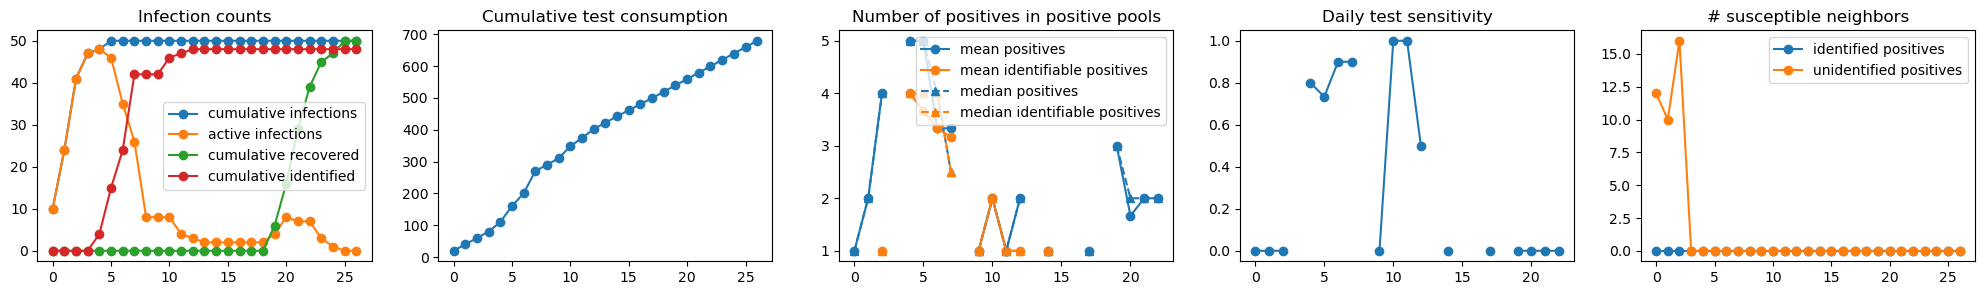

In [15]:
plot_results(sim_correlated)

# Naive

In [113]:
G, households_dict = generate_simplified_network(N, household_size, p_random_edge)

# assign higher weights to intra-household edges

import copy
G_weighted = copy.deepcopy(G)

for node, household in households_dict.items():
    for j in household:
        G[node][j]["weight"] = WEIGHT
        G_weighted[node][j]["weight"] = 10**10
        
sim_naive = run_sim(
    G,
    G_weighted,
    households_dict,
    ALPHA,
    N,
    INIT_PREV,
    T=30,
    pooling_strategy='naive',
    NUM_SCREENING_GROUPS=NUM_SCREENING_GROUPS,
    POOL_SIZE=10,
    LoD=LoD,
    peak_VL=PEAK_VL,
    seed=0,
)


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Running simulation with seed 0 for strategy naive...
Running screening for group 0 on day 0...
Viral loads in positive pools:  [[(3782, -2.0, 3.0)], [(2821, -2.0, 3.0)], [(4644, -2.0, 3.0)], [(955, -2.0, 3.0)], [(1937, -2.0, 3.0)], [(331, -2.0, 3.0)], [(559, -2.0, 3.0)], [(1526, -2.0, 3.0)], [(766, -2.0, 3.0)], [(1389, -2.0, 3.0)], [(686, -2.0, 3.0)], [(1315, -2.0, 3.0)], [(1119, -2.0, 3.0)], [(923, -2.0, 3.0)], [(1115, -2.0, 3.0)], [(940, -2.0, 3.0)], [(4485, -2.0, 3.0), (363, -2.0, 3.0)], [(234, -2.0, 3.0)], [(3095, -2.0, 3.0)]]
Screening day:  0  self.model.t:  0.01
    Nodes with transition propensities:
        node2070, in state [1], propensity [('StoE', 0.37037037037037035)]
infected: 2070, transmissionTerms_I: [10.], transmissionTerms_Q: [0.], household_neighbors: {2072, 2073, 2074, 2071}, non_household_neighbors: [3363, 4233, 3504, 2230, 2070]
Household member states: [array([1]), array([1]), array([1]), array([3])]
Non-household member states: [array([1]), array([1]), array([

In [25]:
for i in range(len(sim_naive.overall_results)):
    print(sim_naive.overall_results[i]["VL_in_positive_pools"])


[[], [(926, -2.56, 3.0)], []]
[[(754, 0.0, 0.7)], [(252, 0.12, 0.69), (254, -2.73, 3.59)]]
[[(805, 0.73, 0.86)], [(314, 0.0, 1.28)], [(807, -2.15, 4.22), (202, 0.0, 1.66)], [(809, 1.25, 0.32), (842, 1.11, 0.58)], [(840, -2.47, 4.04), (808, 1.46, 0.18)]]
[]
[[(959, -3.83, 6.0), (957, 1.58, 2.41)], [(958, 0.74, 2.42)], [(955, 0.62, 3.26)], [(956, 0.86, 2.76)]]
[[(740, 0.0, 4.06)], [(929, 0.34, 4.24)], [(928, 0.26, 4.1), (926, -2.56, 6.0)], [(925, 0.5, 4.59)], [(744, 4.59, 0.15), (857, 0.0, 4.48)], [(856, 4.47, 0.24)], [(927, 3.09, 1.21)], [(858, 2.92, 2.44)]]
[[(751, 5.37, 0.64)], [(753, 5.98, 0.01), (253, 2.32, 3.5)], [(251, 1.6, 3.34)], [(754, 0.0, 5.02), (752, 4.2, 2.54)], [(252, 0.12, 5.26), (254, -2.73, 6.0)], [(250, 3.92, 1.62)]]
[[(312, 4.15, 3.45), (203, 5.46, 2.22)], [(311, 4.38, 3.37), (805, 0.73, 5.37), (313, 6.53, 0.37)], [(844, 4.26, 2.48), (314, 0.0, 5.2), (204, 3.56, 2.88)], [(807, -2.15, 5.7), (841, 2.41, 4.11), (202, 0.0, 6.0)], [(806, 2.31, 5.12)], [(809, 1.25, 5.32), (

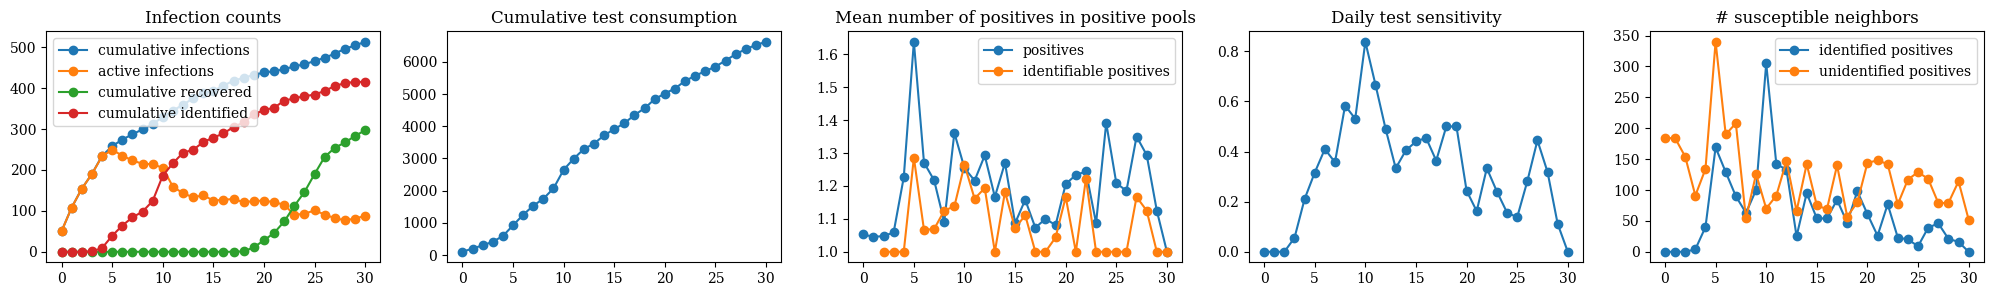

In [114]:
plot_results(sim_naive)

Text(0.5, 1.0, 'Distribution of secondary infections per infectious case, NP')

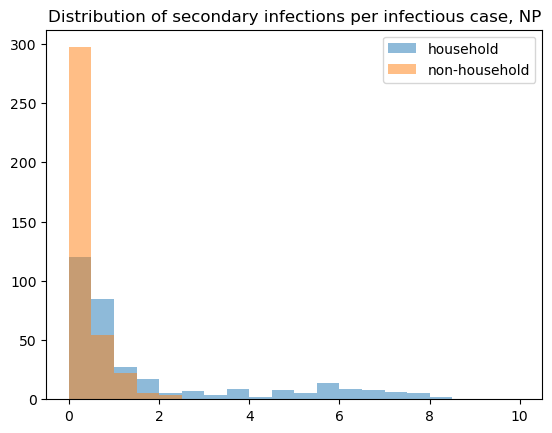

In [193]:
bins=np.linspace(0,10,21)
plt.hist(sim_naive.model.sec_infs_household.values(), bins=bins, alpha=0.5, label="household")
plt.hist(sim_naive.model.sec_infs_non_household.values(), bins=bins, alpha=0.5, label="non-household")
plt.legend()
plt.title("Distribution of secondary infections per infectious case, NP")

Text(0.5, 1.0, '# susceptible neighbors')

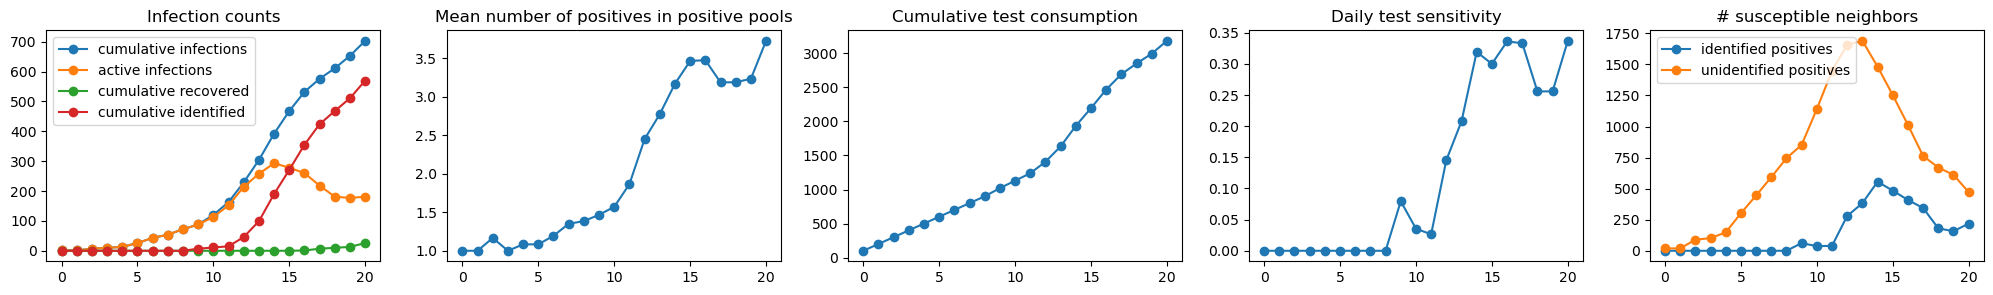

In [192]:
fig, axs = plt.subplots(1, 5, figsize=(25, 3))

sim = sim_naive

axs[0].plot([sim.overall_results[i]["cumInfections"] for i in range(len(sim.overall_results))], "-o", label="cumulative infections")
axs[0].plot([sim.overall_results[i]["numActiveInfections"] for i in range(len(sim.overall_results))], "-o", label="active infections")
axs[0].plot([sim.overall_results[i]["cumRecovered"] for i in range(len(sim.overall_results))], "-o", label="cumulative recovered")
axs[0].plot([sim.overall_results[i]["cum_positives_identified"] for i in range(len(sim.overall_results))], "-o", label="cumulative identified")
axs[0].legend()
axs[0].set_title("Infection counts")

axs[1].plot([sim.overall_results[i]["mean_num_positives_in_positive_pool"] for i in range(len(sim.overall_results))], "-o", label="mean_num_positives_in_positive_pool")
axs[1].set_title("Mean number of positives in positive pools")

axs[2].plot([sim.overall_results[i]["cum_num_tests"] for i in range(len(sim.overall_results))], "-o", label="cum_num_tests")
axs[2].set_title("Cumulative test consumption")

axs[3].plot([sim.overall_results[i]["daily_sensitivity"] for i in range(len(sim.overall_results))], "-o", label="daily_sensitivity")
axs[3].set_title("Daily test sensitivity")

axs[4].plot([sim.overall_results[i]["num_susceptible_neighbors_of_identified_positives"] for i in range(len(sim.overall_results))], "-o", label="identified positives")
axs[4].plot([sim.overall_results[i]["num_susceptible_neighbors_of_unidentified_positives"] for i in range(len(sim.overall_results))], "-o", label="unidentified positives")
axs[4].legend()
axs[4].set_title("# susceptible neighbors")

In [66]:
len(sim_naive.model.infectionsLog)

99